# Plot some OLBIN publication database

#### Load modules and define common functions

In [1]:
#!pip install pandas matplotlib ipympl requests

# load some modules for later use
import requests
import pandas
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict 

%pylab inline

# define some common plot settings
plt.rcParams['figure.figsize'] = [17, 8]
# Set the default color cycle
colormap = plt.get_cmap('tab20').colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colormap) 
plt.rc('font', size=20)


# define a stack plot function
def plotStackedOlbinTags(tags,title, min_year, max_year=None ):    
    if not min_year:
        min_year = min(olbin.YEAR)
    
    if not max_year:
        max_year = max(olbin.YEAR)+1
        
    xticksNb = int( (max_year-min_year) / 12 )
    print("%d xticks for %d %d"%(xticksNb, min_year, max_year))
    
    cols = {}
    for (k,v) in olbin.items():
        if k in tags:
            cols[k]=v

    #split into 2 list given list's sum  " TODO make it adjustable param or detection of long input lists...
    sums=  OrderedDict( (key, sum(value)) for (key,value) in cols.items())
    sorted_by_sum= sorted(sums, key=sums.get)
    m=int(len(cols)/2)
    scols1=OrderedDict()
    scols2=OrderedDict()
    scols=OrderedDict()

    for name in reversed(sorted_by_sum):
        scols[name]=cols[name]
        if name in sorted_by_sum[0:m]:
            scols2[name]=cols[name]
        else:
            scols1[name]=cols[name]

    # loop overs subsets
    #subsets = (scols, scols1, scols2)
    subsets = (scols1, scols2)
    #subsets = [scols]
    # for stacked bars
    for scols in subsets:                
        fig, ax = plt.subplots()
        flag = True
        for c in scols:          
            if flag:
                ax.bar(olbin.YEAR, scols[c], label=c+" ("+str(sum(scols[c]))+")")
                flag=False
                bot=scols[c]
            else:
                ax.bar(olbin.YEAR, scols[c], bottom=bot, label=c+" ("+str(sum(scols[c]))+")")            
                bot= np.add(bot, scols[c]).tolist()                    
        ax.set_xlim(min_year,max_year)
        ax.set_xticks(np.arange(min_year,max_year, xticksNb))
        ax.legend(loc='upper left')    
        ax.set_title(title)
        fig.tight_layout()

    # for stacket plot    
    if False:
    #if True:
      for scols in subsets:        
        values=[]
        fig, ax = plt.subplots()
        for c in scols:
            values.append(scols[c])
        ax.stackplot(olbin.YEAR, values, labels=scols)
        ax.set_xlim(min_year,max_year)
        ax.set_xticks(np.arange(min_year,max_year, xticksNb))
        ax.legend(loc='upper left')        
        fig.tight_layout()


Populating the interactive namespace from numpy and matplotlib


#### Load main dataset (csv format & json)

In [2]:
olbin = pandas.read_csv("http://bibdbmgr.jmmc.fr/tags.xql")
olbinAstro = pandas.read_csv("http://bibdbmgr.jmmc.fr/tags.xql?keep-tag=Astrophysical+results") # use keep-tag to get Astroresults dataset
categories = requests.get("http://bibdbmgr.jmmc.fr/categories.xql").json()
print("Olbin's categories are :\n\t %s" % ", ".join(categories.keys()))

Olbin's categories are :
	 HIDDEN, MainCategory, Instrument, Wavelength, Astrophysical topic, Technique, Facility, Spectral Resolution


# Display impact on scientific results for in general, on facilities with more than 25 papers and JMMC 

/tmp/ipykernel_762956/1585419664.py:3: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


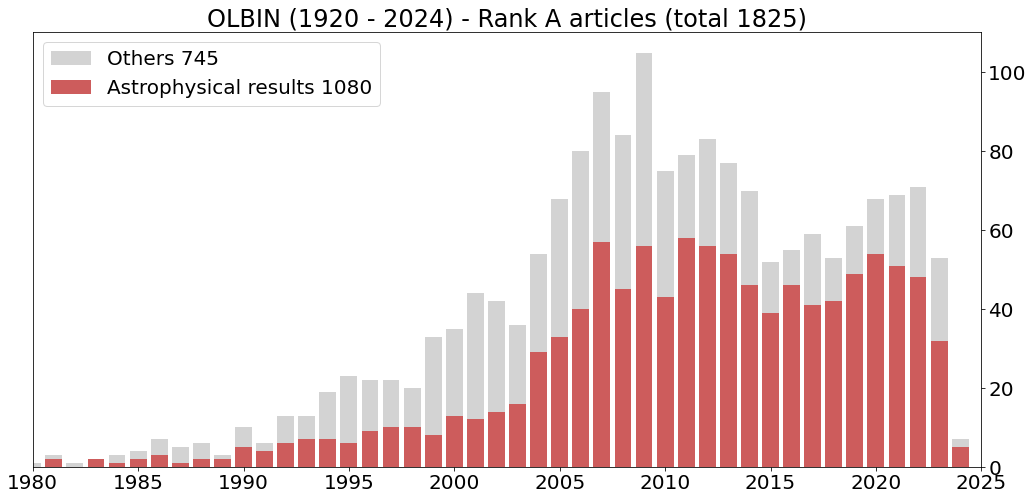

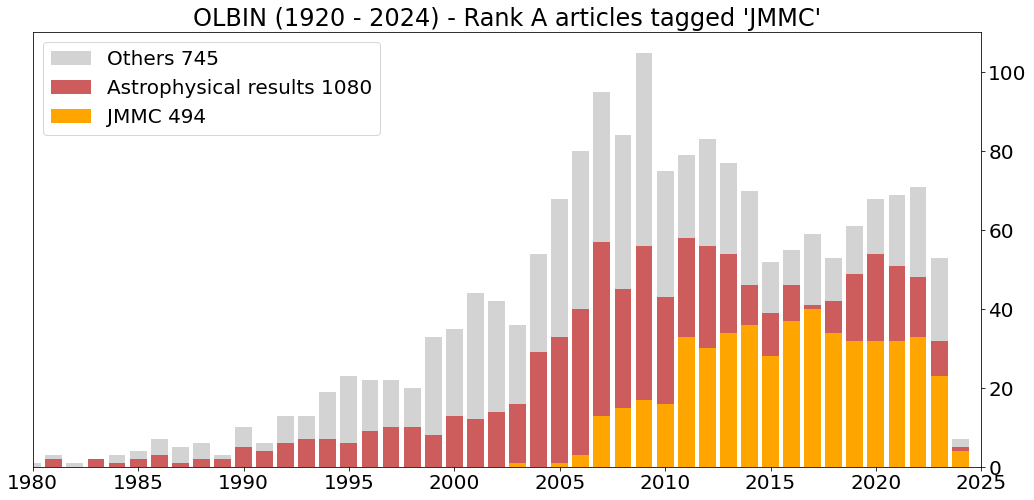

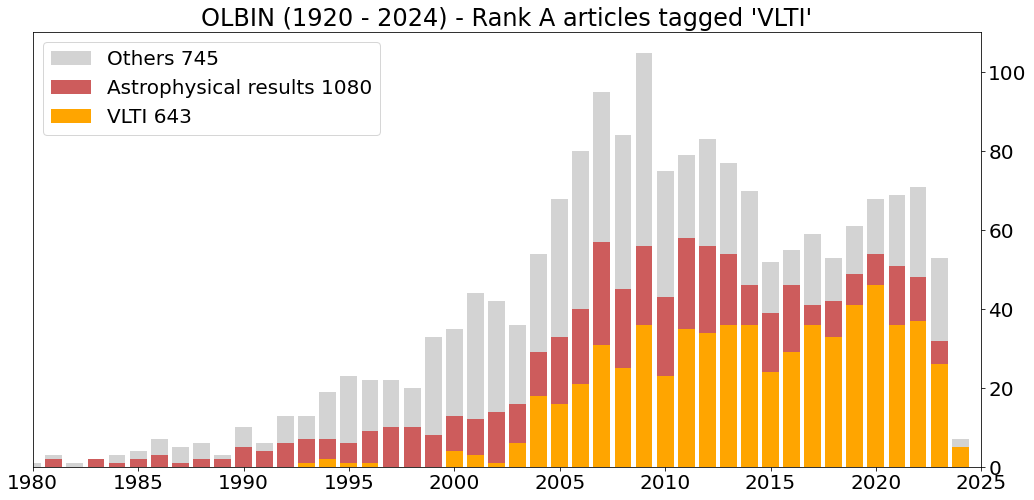

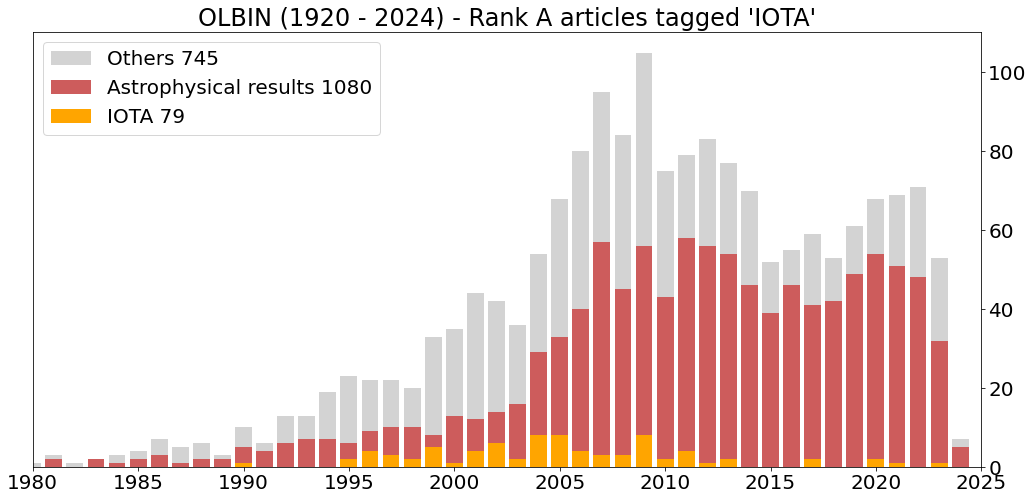

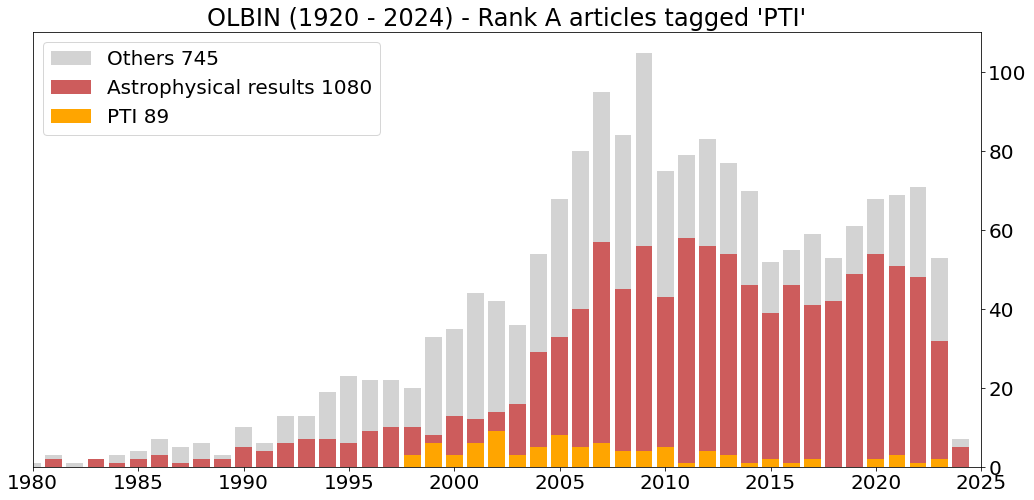

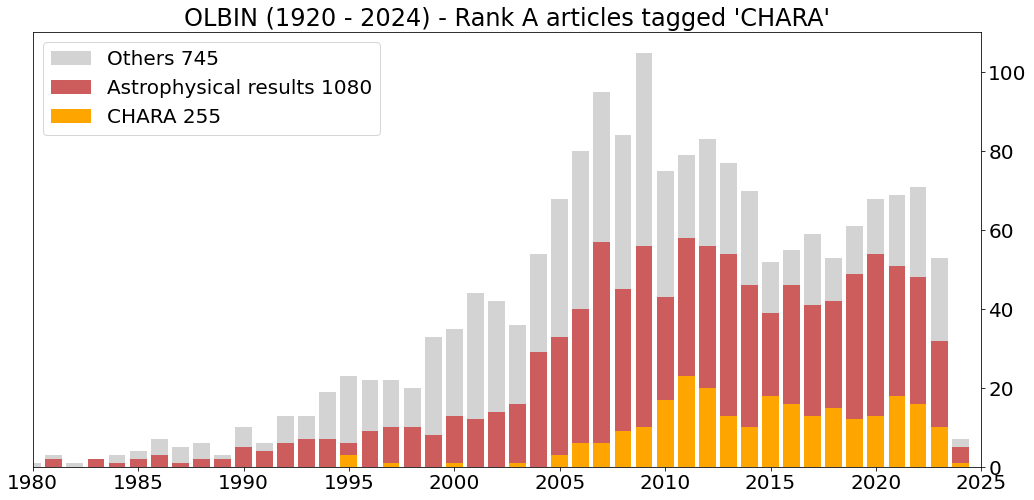

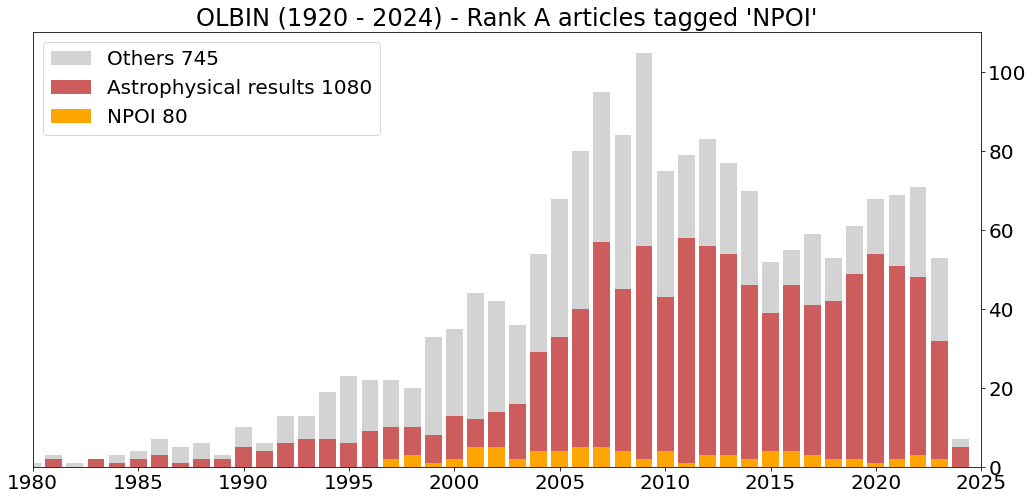

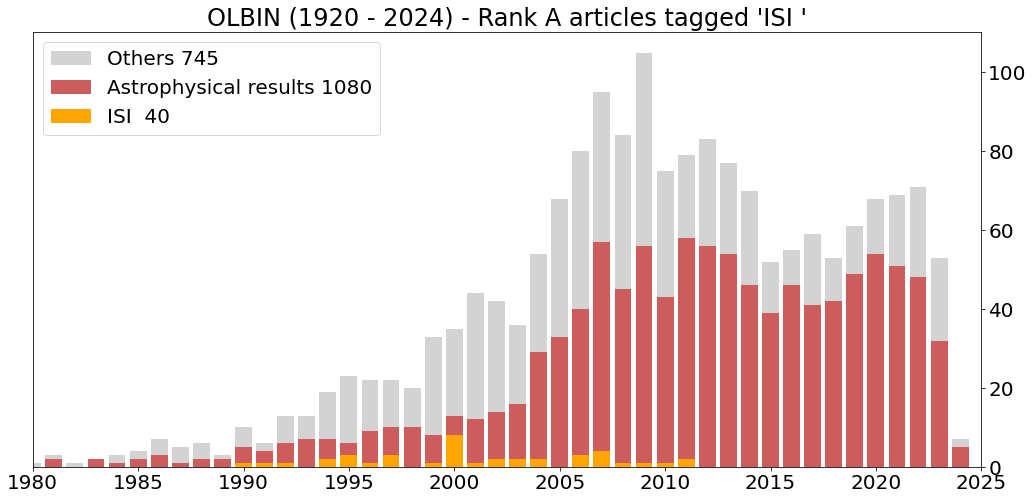

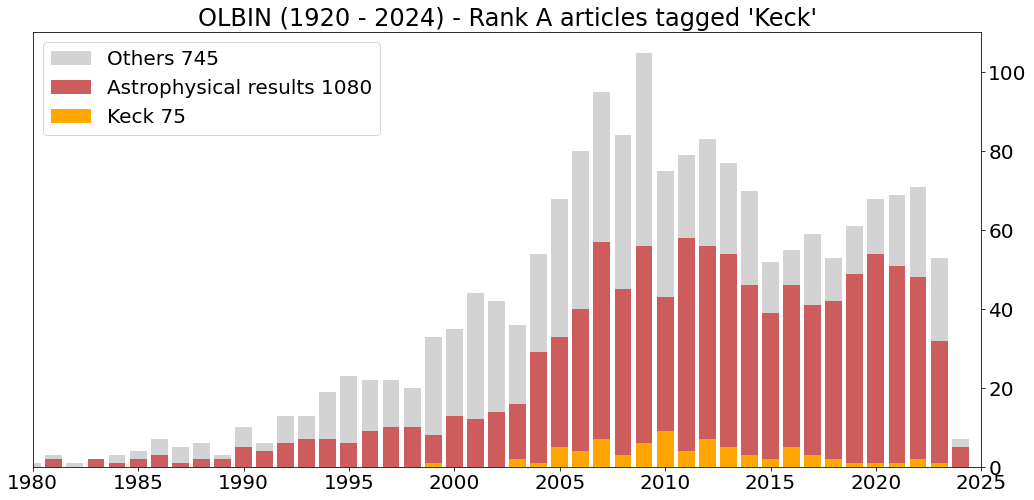

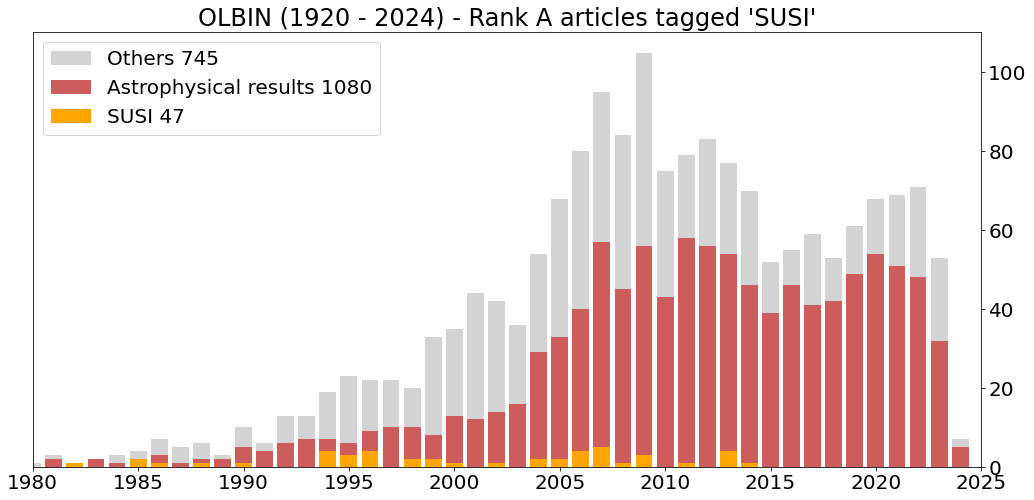

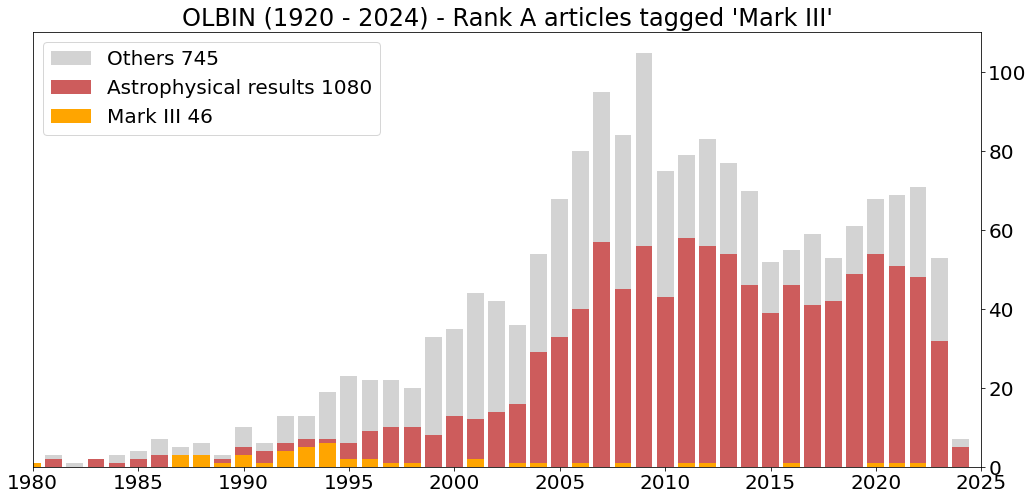

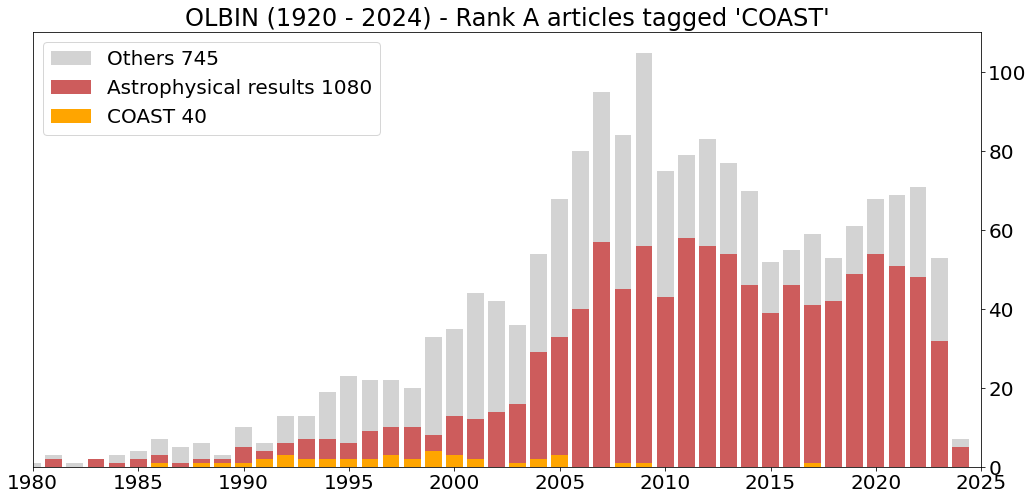

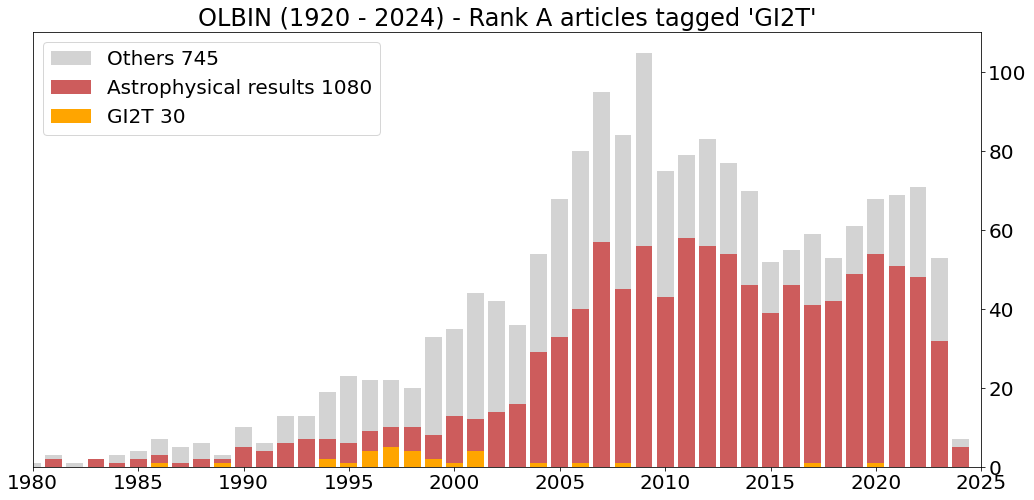

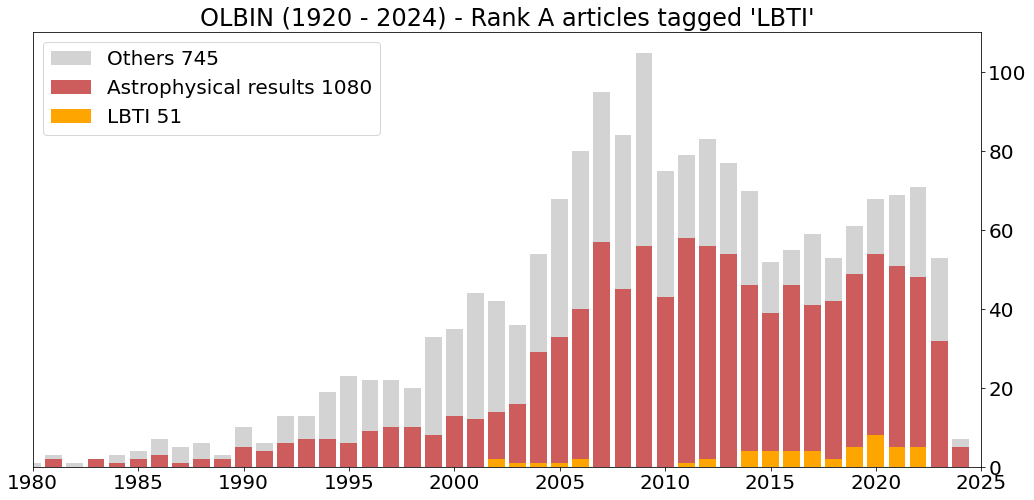

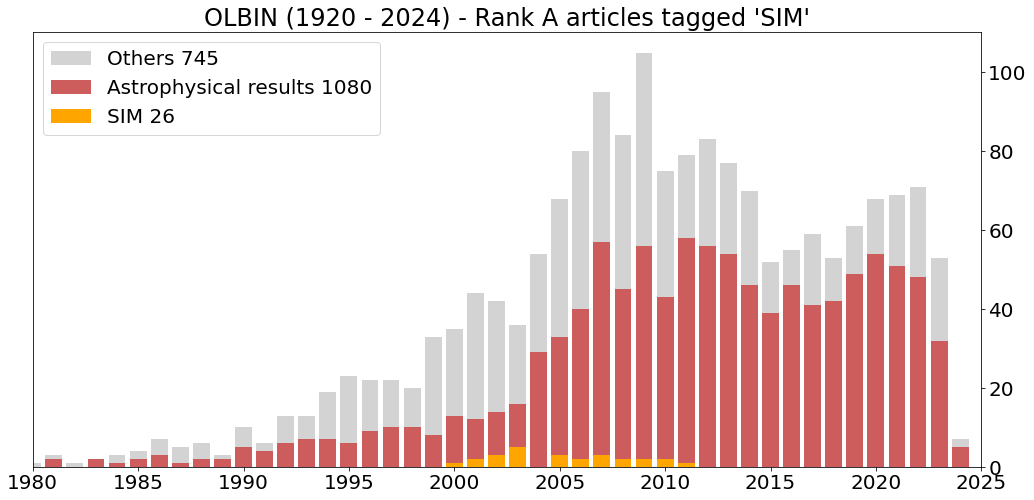

In [3]:
# reuse main datasource 
#olbin = pandas.read_csv("http://bibdbmgr.jmmc.fr/tags.xql")
from scipy.ndimage.filters import gaussian_filter1d

add_percent=False # please check if you set to True, it seems wrong...
tags=[]
tags.append(None) # None is added to compute first general diagram
tags.append("JMMC")
tags+=[c for c in categories["Facility"] if sum(olbin[c])>25]

#for tag in (None,"CHARA", "VLTI","JMMC"):
for tag in tags: 
    # create data sets
    s={}
    s1=s["Others"]=olbin.total_pubs
    s2=s["Astrophysical results"]=olbin["Astrophysical results"]
    if tag :        
        s3=s[tag]=olbin[tag]
        s3a=olbinAstro[tag]        
        s4=(100*s3a/s3).replace(NaN, 0) # handle div by zero using 0 as first workarround         
    else:
        s4=s["%"]=(100*s2/s1).replace(NaN, 0) # handle div by zero using 0 as first workarround
        
    
        
    #TODO generates legend info dynamically from previous dataset
    
    # figure
    fig, ax = plt.subplots()
    p1 = ax.bar(olbin.YEAR, s1, color='lightgrey')
    p2 = ax.bar(olbin.YEAR, s2, color='indianred')
        
    if tag :
        p3 = ax.bar(olbin.YEAR, s3, color='orange')            
        op = ax.set_title("OLBIN (%s - %s) - Rank A articles tagged '%s'"%(min(olbin.YEAR), max(olbin.YEAR), tag ))
        op = ax.legend((p1[0], p2[0],p3[0]), ("Others "+str(sum(s1) - sum(s2)),"Astrophysical results "+str(sum(s2)), tag+" "+str(sum(s3))), loc='upper left')        
    else :
        op = ax.set_title("OLBIN (%s - %s) - Rank A articles (total %d)"%(min(olbin.YEAR), max(olbin.YEAR), sum(s1)))
        op = ax.legend((p1[0], p2[0]), ("Others "+str(sum(s1) - sum(s2)),"Astrophysical results "+str(sum(s2))), loc='upper left')    
    
    
    if add_percent:        
        s4=gaussian_filter1d(s4, sigma=2)
        p4 = ax.plot (olbin.YEAR, s4, color='black', linewidth=3)
    #    op = ax.legend((p1[0], p2[0],p4[0]), ("Others "+str(sum(s1) - sum(s2)),"Astrophysical results "+str(sum(s2)), "% of Astrophysical results "), loc='upper left')    
    

        
    op = ax.set_xlim(1980,max(olbin.YEAR)+1)
    op = ax.yaxis.tick_right()

# Look at facilities

5 xticks for 1960 2025


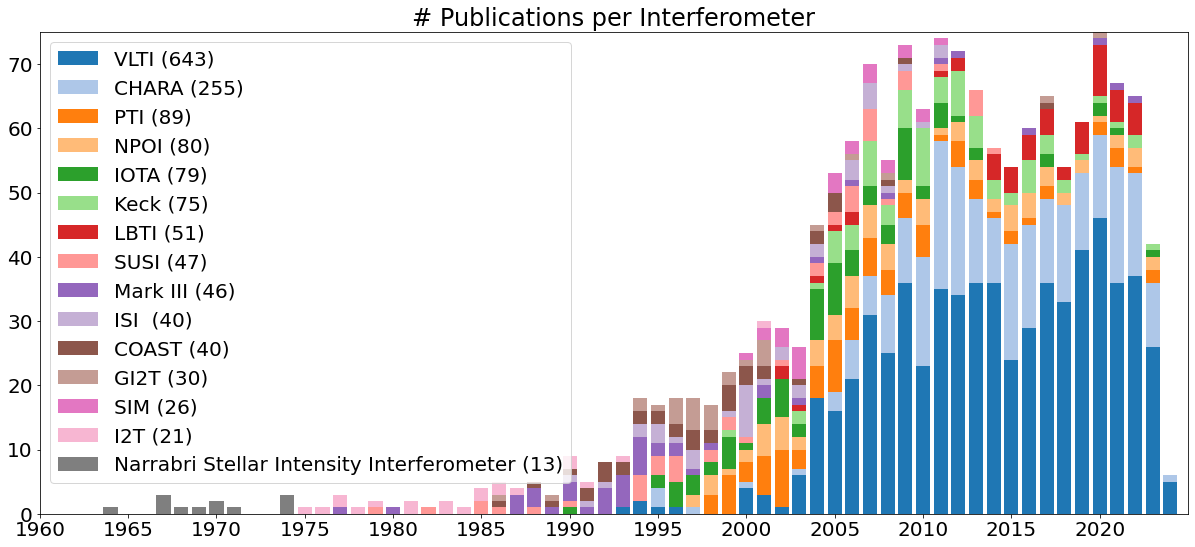

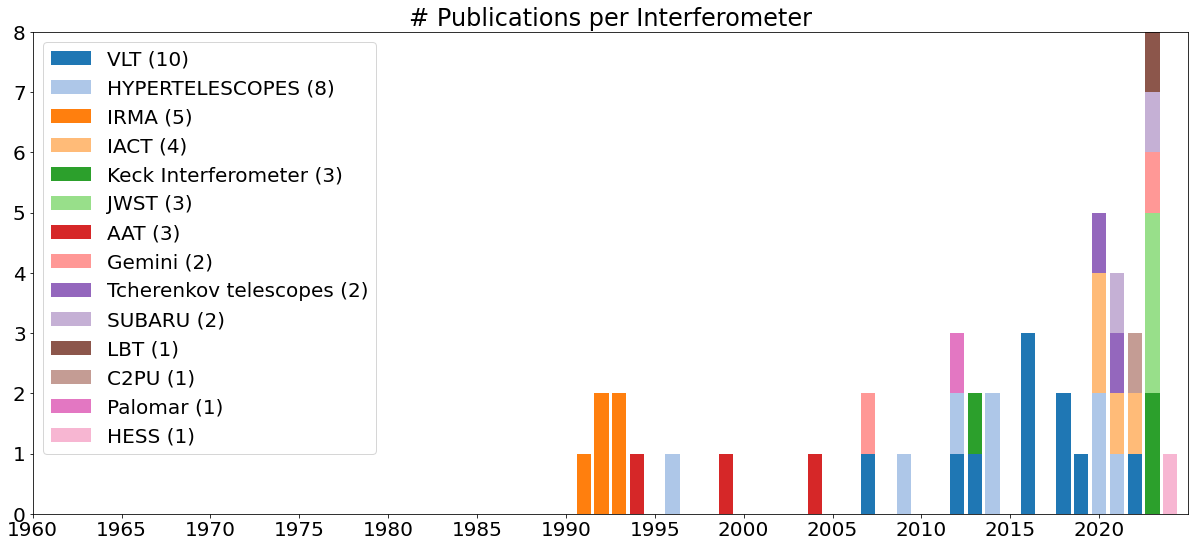

In [4]:
plotStackedOlbinTags(categories["Facility"], "# Publications per Interferometer", 1960)

2 xticks for 1995 2025


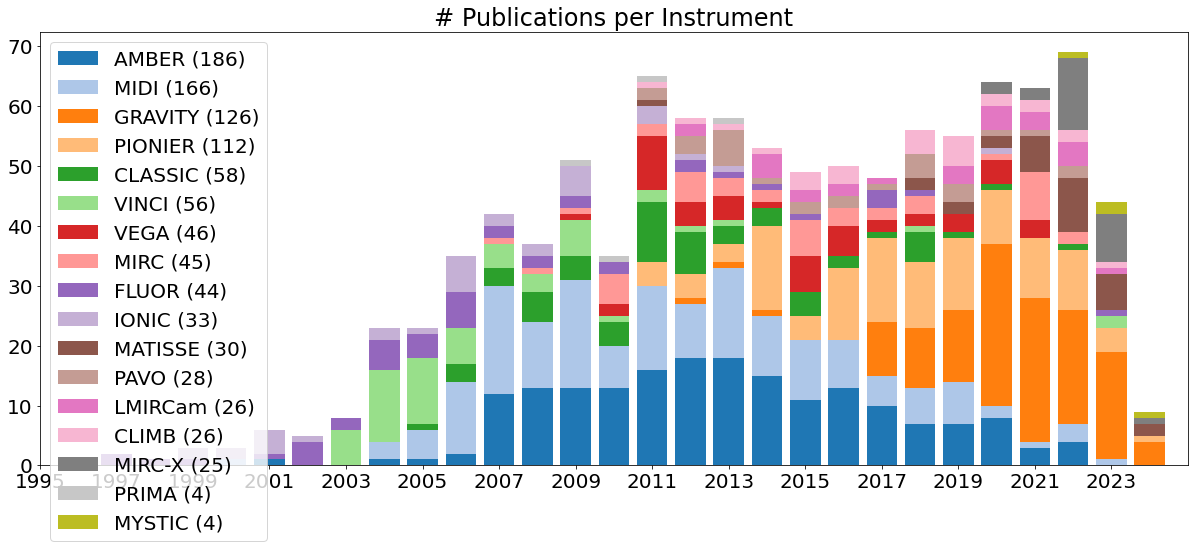

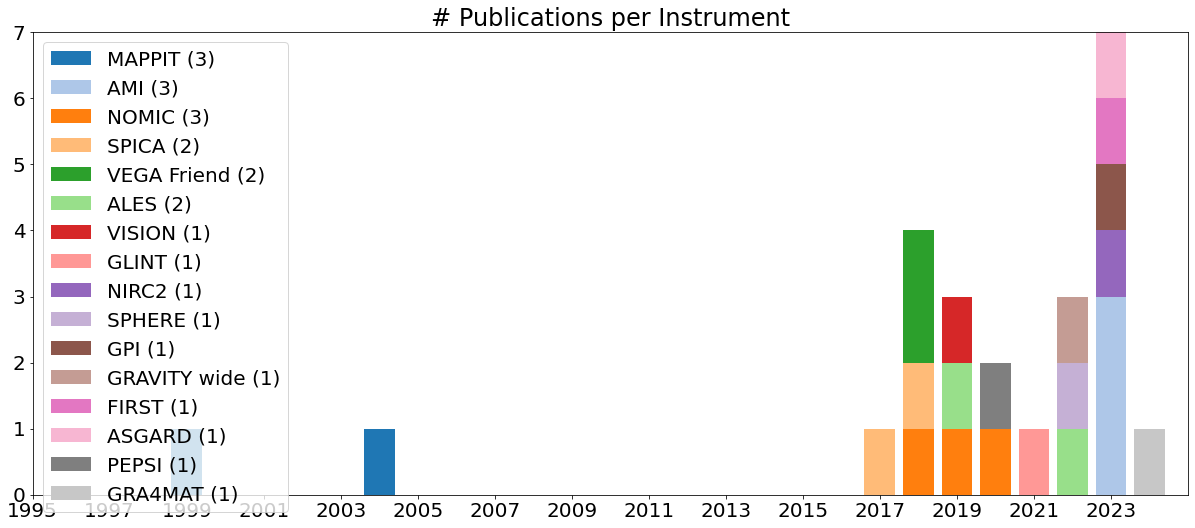

In [5]:
plotStackedOlbinTags(categories["Instrument"], "# Publications per Instrument", 1995)

# Follow JMMC products cited in the OLBIN corpus

1 xticks for 2003 2025


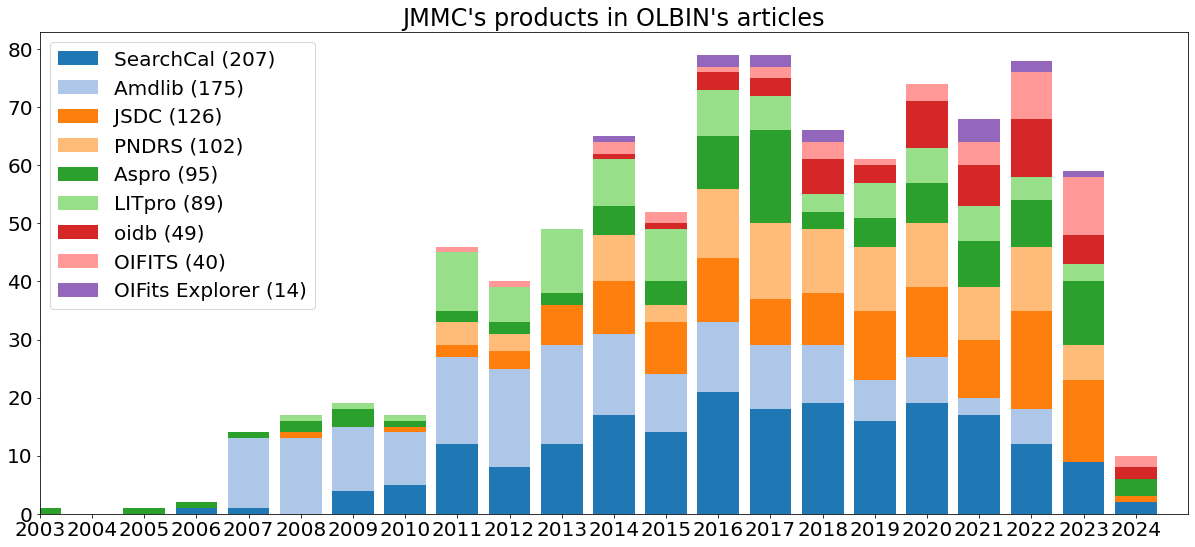

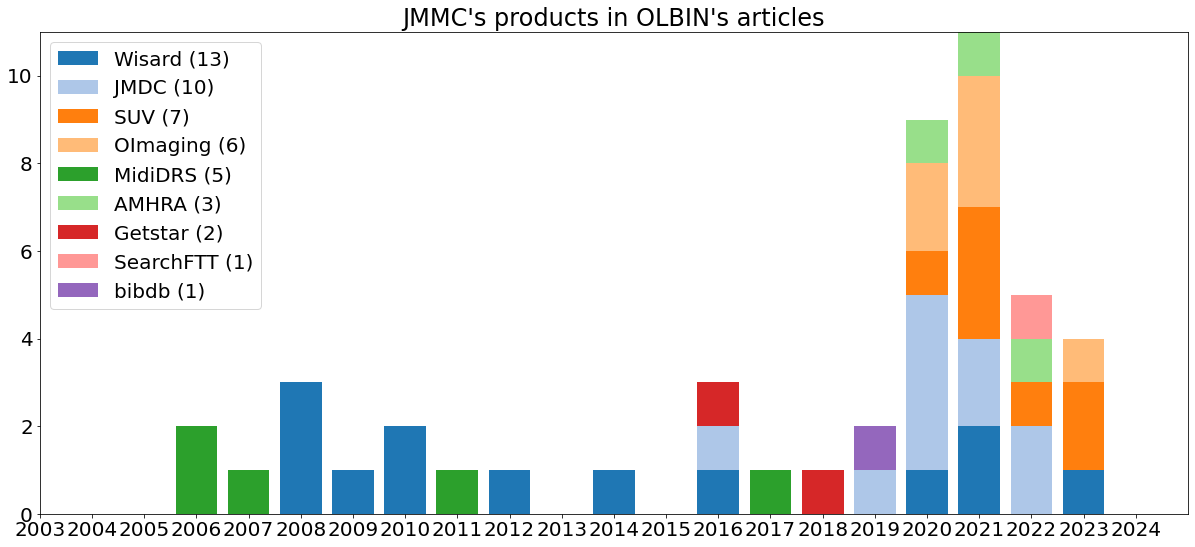

In [6]:
tags = [tag for tag in categories["HIDDEN"] if not "JMMC" in tag]  # Filter JMMC out
plotStackedOlbinTags( tags ,"JMMC's products in OLBIN's articles", 2003)